In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'


In [2]:
import pydicom
from matplotlib import pyplot as plt


3056 2544


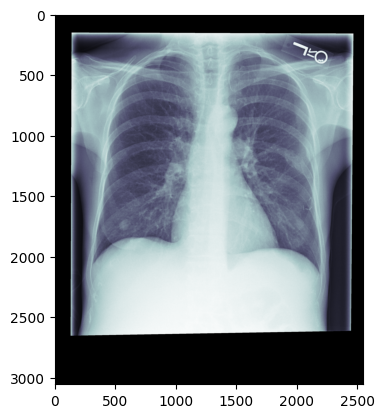

In [3]:
# load dcm
image = pydicom.dcmread("data/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm")
# print length, width of pixel array
print(len(image.pixel_array), len(image.pixel_array[0]))
# show image content
plt.imshow(image.pixel_array, cmap=plt.cm.bone)


/tmp/ipykernel_563063/2921340360.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil = Image.fromarray(np.uint8(px * 255), mode="L").convert("RGB")


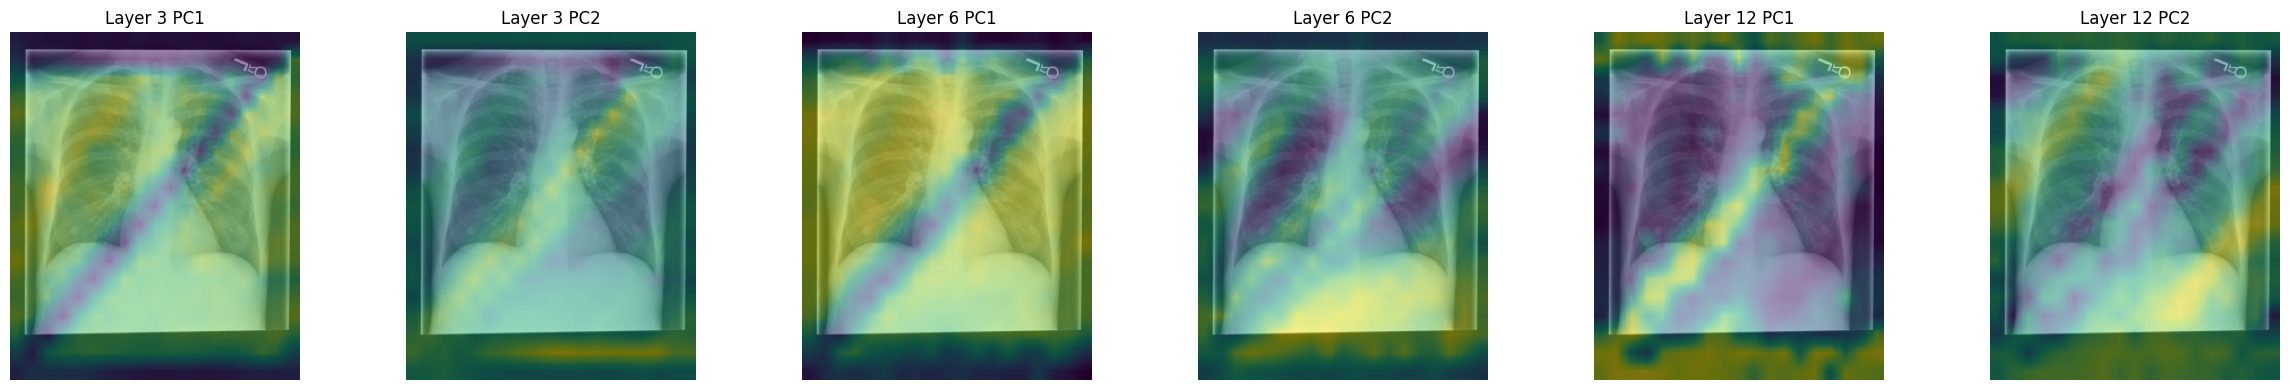

In [10]:
# pip install torch torchvision transformers timm pydicom pillow scikit-learn
import pydicom
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA

from transformers import AutoImageProcessor, Dinov2Model

# -----------------------------
# DICOM → uint8 RGB (for viz) and HF-ready PIL image
# -----------------------------
def dicom_to_pil(ds: pydicom.dataset.FileDataset):
    px = ds.pixel_array.astype(np.float32)

    slope = float(getattr(ds, "RescaleSlope", 1.0))
    intercept = float(getattr(ds, "RescaleIntercept", 0.0))
    px = px * slope + intercept

    if hasattr(ds, "WindowCenter") and hasattr(ds, "WindowWidth"):
        wc = float(np.atleast_1d(ds.WindowCenter)[0])
        ww = float(np.atleast_1d(ds.WindowWidth)[0])
        lo, hi = wc - ww / 2.0, wc + ww / 2.0
        px = np.clip(px, lo, hi)
    else:
        lo, hi = np.percentile(px, 0.5), np.percentile(px, 99.5)
        px = np.clip(px, lo, hi)

    px = (px - px.min()) / (px.max() - px.min() + 1e-8)
    pil = Image.fromarray(np.uint8(px * 255), mode="L").convert("RGB")
    return pil

# -----------------------------
# DINOv2 model + processor
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "models/dinov2-base"  # ViT-B/14
processor = AutoImageProcessor.from_pretrained(model_id)
model = Dinov2Model.from_pretrained(model_id, output_hidden_states=True).to(device).eval()

# -----------------------------
# Feature → spatial map + PCA → heatmaps
# -----------------------------
def tokens_to_grid(hidden: torch.Tensor):
    """
    hidden: [1, N, C] token sequence (includes CLS at index 0)
    returns grid tensor [H, W, C] without CLS
    """
    seq = hidden[:, 1:, :]  # drop CLS
    n = seq.shape[1]
    h = w = int(np.sqrt(n))
    grid = seq[:, : h*w, :].reshape(1, h, w, -1).squeeze(0)  # [h,w,C]
    return grid  # [h,w,C] on same device

def upsample_to(img_hw, fmap_hw_c: torch.Tensor):
    H, W = img_hw
    fmap = fmap_hw_c.permute(2,0,1).unsqueeze(0)  # [1,C,h,w]
    fmap_up = torch.nn.functional.interpolate(fmap, size=(H, W), mode="bilinear", align_corners=False)
    return fmap_up.squeeze(0).permute(1,2,0)  # [H,W,C]

def pca_heatmaps(fmap_hw_c: torch.Tensor, k=3):
    H, W, C = fmap_hw_c.shape
    X = fmap_hw_c.reshape(-1, C).detach().cpu().numpy()
    X = (X - X.mean(0, keepdims=True)) / (X.std(0, keepdims=True) + 1e-6)
    p = PCA(n_components=k, svd_solver="randomized")
    comps = p.fit_transform(X).reshape(H, W, k)
    outs = []
    for i in range(k):
        m = comps[..., i]
        m = (m - m.min()) / (m.max() - m.min() + 1e-8)
        outs.append(m)
    return outs  # list of [H,W] in [0,1]

def show_overlays(rgb8, heatmaps, titles, alpha=0.45, cmap="viridis"):
    n = len(heatmaps)
    plt.figure(figsize=(4*n, 4))
    for i, m in enumerate(heatmaps):
        plt.subplot(1, n, i+1)
        plt.imshow(rgb8)
        plt.imshow(m, cmap=cmap, alpha=alpha, interpolation="nearest")
        plt.axis("off")
        plt.title(titles[i])
    plt.tight_layout()
    plt.show()

# -----------------------------
# End-to-end: run DINOv2 and visualize a few layers
# -----------------------------
# You have:
# image = pydicom.dcmread("data/02aa804e-bde0afdd-112c0b34-7bc16630-4e384014.dcm")
pil = dicom_to_pil(image)

# Use Dinov2's default preprocessing. Size is handled by the processor (shortest_edge≈518 for Dinov2).
inputs = processor(images=pil, return_tensors="pt", do_center_crop=False).to(device)

with torch.no_grad():
    out = model(**inputs)  # last_hidden_state, hidden_states (embeddings + each layer)

hidden_states = out.hidden_states  # tuple(len=L+1), each [1, seq, dim]
# Pick a few depths. Index 0 is patch embeddings pre-block. Then blocks 1..12 for base.
layer_ids = [3, 6, 12]  # early, mid, last block outputs

# Build a background image that matches processor output size
proc_h = inputs["pixel_values"].shape[-2]
proc_w = inputs["pixel_values"].shape[-1]
bg = pil.resize((proc_w, proc_h))  # uint8 RGB for overlay

to_show, titles = [], []
for lid in layer_ids:
    grid = tokens_to_grid(hidden_states[lid])              # [h,w,C]
    grid_up = upsample_to((proc_h, proc_w), grid)          # [H,W,C]
    pcs = pca_heatmaps(grid_up, k=2)                       # two PCs per layer for brevity
    to_show.extend(pcs)
    titles.extend([f"Layer {lid} PC1", f"Layer {lid} PC2"])
    if len(to_show) >= 6:
        break

show_overlays(np.array(bg), to_show, titles, alpha=0.5)
